Emotive for LSL realtime

https://www.emotiv.com/blogs/tutorials/emotiv-lab-streaming-layer-lsl

FFT

https://github.com/KrishnaVeer7712/DIGITS-CLASSIFICATIONS-USING-ELECTROENCEPHALOGRAPHY-SIGNALS/blob/master/Brain_123%20(1).ipynb

https://github.com/ayushayt/ImaginedSpeechRecognition

In [21]:
import mne
import os
import numpy as np

root_folder = "./data/emotiv/Digit"


X = np.zeros((230,14,1280))
Y = np.zeros((230,))

ctr = 0

for file in os.listdir(root_folder):
    if file.endswith(".edf"):
        data = mne.io.read_raw_edf(os.path.join(root_folder,file))
        raw_data = data[2:16][0]*1000
        raw_data = raw_data[:,0:1280]
        #a = raw_data.shape
        
        _,cls = file.split('_')
        Y[ctr] = int(cls[0])
        X[ctr,:,:] = raw_data
        ctr = ctr+1

print(ctr)

Extracting EDF parameters from /Users/hunkim/Github/studio-brain/data/emotiv/Digit/shubhamtiwari_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/hunkim/Github/studio-brain/data/emotiv/Digit/Vipin_7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/hunkim/Github/studio-brain/data/emotiv/Digit/Rajkumarsaini_7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/hunkim/Github/studio-brain/data/emotiv/Digit/ChandanSingha_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/hunkim/Github/studio-brain/data/emotiv/Digit/Nishant_9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/hunkim/Github/studio-brain/data

In [45]:
# read test sample
sample_file = "./data/emotiv/sample.edf"
data = mne.io.read_raw_edf(sample_file)
raw_data = data[2:16][0]
raw_data = raw_data[:,0:1280]

test_X = raw_data

print(test_X.shape)

print(test_X[12] * 1000)

Extracting EDF parameters from /Users/hunkim/Github/studio-brain/data/emotiv/sample.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(14, 1280)
[4.32153846 4.32       4.31589744 ... 4.29076923 4.28512821 4.28564103]


In [43]:
# find unique value of Y
np.unique(Y)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
# we have 14 channels 
X_new = np.zeros((36110,32,14))
Y_new = np.zeros((36110,))
npt = 32 # number of points
stride = 8 # stride, i.e. how many points to skip
ctr = 0
for i in range(0,230):
    y = Y[i]
    a= X[i,:,:]
    a = a.transpose()
    val = 0
    while val<=(len(a)-npt):
        x = a[val:val+npt,:]
        X_new[ctr,:,:] = x
        Y_new[ctr] = y
        val = val+stride
        ctr = ctr+1

In [48]:
X_new.shape

(36110, 32, 14)

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=1)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)  # Long for classification targets
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the PyTorch model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(14)  # Channels should match input shape
        self.conv1 = nn.Conv1d(14, 128, kernel_size=10, stride=1, padding='same')
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Switch to (batch, channels, sequence)
        x = self.batch_norm1(x)
        x = F.relu(self.conv1(x))
        x = self.batch_norm2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # Reorder for LSTM (batch, sequence, input_size)
        x, _ = self.lstm(x)
        x = self.batch_norm3(x[:, -1, :])  # Use the last LSTM output
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)


Epoch 1, Validation Accuracy: 0.21566048186098033
Test Accuracy: 0.2035447244530601


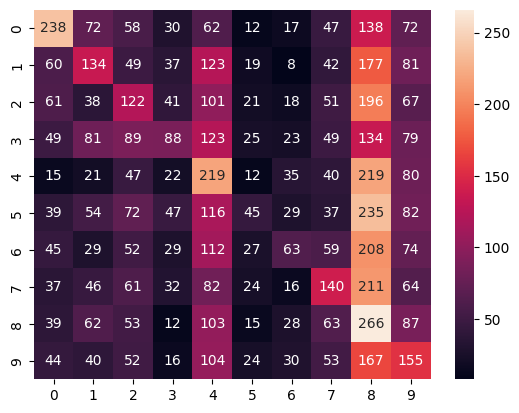

In [56]:
# Instantiate model, define loss and optimizer
model = EEGNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping criteria
best_accuracy = 0
patience = 10
trigger_times = 0

# Training loop
for epoch in range(1):
    model.train()
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train)
        val_loss = criterion(val_outputs, Y_train)
        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(Y_train.numpy(), val_preds.numpy())
        print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy}")

        # Early stopping logic
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping")
                break

# Testing and evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, Y_pred = torch.max(test_outputs, 1)
    accuracy = accuracy_score(Y_test, Y_pred)
    print("Test Accuracy:", accuracy)

    # Confusion Matrix
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g')